In [2]:
import math
#to read data from the web
import pandas_datareader as web 
#to perform numerical computations
import numpy as np 
#for data manipulation and analysis
import pandas as pd
#to normalize and scale the data
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
#to build the model layer by layer
from tensorflow.keras.models import Sequential
#for time series prediction - Long Short Term Memory
from tensorflow.keras.layers import Dense, LSTM
#to plot the graphs
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
#download market data from yahoo finance
import yfinance as yf

In [3]:
#download the stock market data for Tesla (TSLA) from yahoo finance and assign it to data frae df
df = yf.download('TSLA', start='2019-01-01', end='2024-06-01')
df

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02,20.406668,21.008667,19.920000,20.674667,20.674667,174879000
2019-01-03,20.466667,20.626667,19.825333,20.024000,20.024000,104478000
2019-01-04,20.400000,21.200001,20.181999,21.179333,21.179333,110911500
2019-01-07,21.448000,22.449333,21.183332,22.330667,22.330667,113268000
2019-01-08,22.797333,22.934000,21.801332,22.356667,22.356667,105127500
...,...,...,...,...,...,...
2024-05-24,174.839996,180.080002,173.729996,179.240005,179.240005,65479700
2024-05-28,176.399994,178.250000,173.160004,176.750000,176.750000,59736600
2024-05-29,174.190002,178.149994,173.929993,176.190002,176.190002,54782600


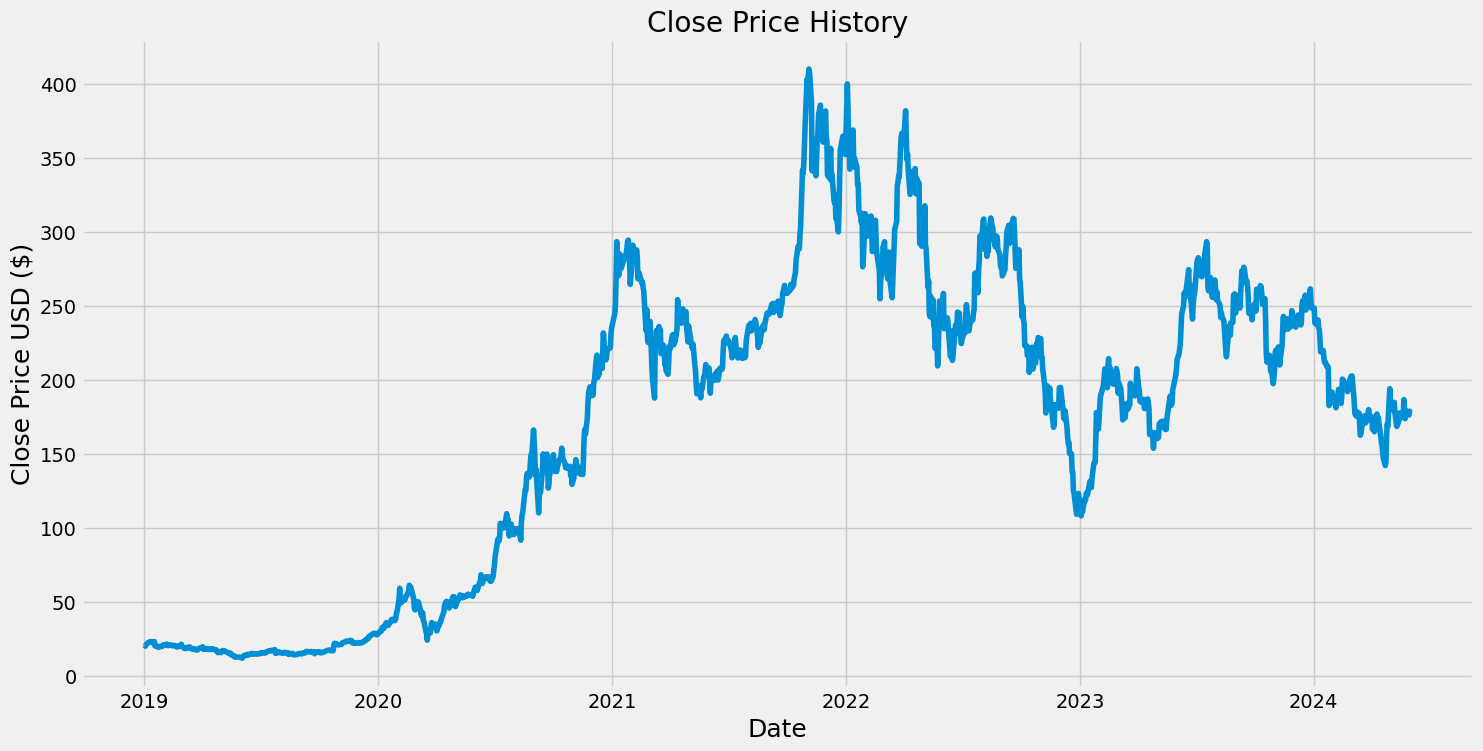

In [4]:
#plot the financial information from the stock data into a visual form
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD ($)',fontsize=18)
plt.show()

In [5]:
#filter the data frame to contain only the cloding price column
data = df.filter(['Close'])
#convert the data frame into a numpy array 
dataset = data.values
#we will use 80% of the totla number of rows to train the dataset
training_data_len = math.ceil(len(dataset) * .8)
training_data_len

1091

In [6]:
#create an instance of MinMaxScaler to scale all features to range 0 to 1
scaler = MinMaxScaler(feature_range=(0,1))
#scale all values in dataset between the range 0 to 1
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.02196604],
       [0.02033136],
       [0.02323392],
       ...,
       [0.41267013],
       [0.41920214],
       [0.41741841]])

In [7]:
#extract training data
train_data = scaled_data[0:training_data_len, :]
#create and initialise empty lists for training data
x_train = []
y_train = []
#create sequential data for lstm
for i in range(60, len(train_data)):
    #appends the previous 60 closing prices to x_train
    x_train.append(train_data[i-60:i, 0])
    #appends the next closing price to y_train
    #target output based on the input sequence
    y_train.append(train_data[i, 0])
    if i <= 60:
        print(x_train)
        print(y_train)
        print()

[array([0.02196604, 0.02033136, 0.02323392, 0.02612644, 0.02619176,
       0.02672437, 0.02780299, 0.02818654, 0.02603265, 0.02771255,
       0.02798388, 0.02819492, 0.02064959, 0.02009018, 0.01819254,
       0.01884909, 0.0197753 , 0.01966476, 0.01984565, 0.02173993,
       0.02144683, 0.02231609, 0.02242998, 0.02384693, 0.02315521,
       0.0215289 , 0.0212425 , 0.02242161, 0.02224909, 0.02163944,
       0.02090249, 0.02159087, 0.02121569, 0.02069984, 0.01880219,
       0.01938505, 0.02006505, 0.01991264, 0.02273984, 0.02360072,
       0.01939845, 0.01781904, 0.0163418 , 0.01629155, 0.01635017,
       0.01761471, 0.01875027, 0.01748407, 0.018422  , 0.01858949,
       0.01615588, 0.01516101, 0.01482268, 0.01584938, 0.01591973,
       0.01433026, 0.01364189, 0.01487293, 0.01605539, 0.01669017])]
[0.016897857710496657]



In [9]:
x_train, y_train = np.array(x_train), np.array(y_train)

In [10]:
#to fit the requirements of lstm
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(1031, 60, 1)

In [11]:
#add layers one after another
model = Sequential() #Sequential() creates a new neural network
#add lstm layer which returns the sequence rather than the last output
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
#add lstm layer which return only the last output
model.add(LSTM(50, return_sequences=False))
#layer to learn the non-linear relationship in the data
model.add(Dense(25))
model.add(Dense(1))

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [12]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [21]:
model.fit(x_train, y_train, batch_size=1, epochs=1)

1031/1031 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.0081


In [22]:
#extract scaled data to generate sequence
test_data = scaled_data[training_data_len - 60:, :]
x_test = []
y_test = dataset[training_data_len:, :]
#create sequential test data
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])   

In [23]:
x_test = np.array(x_test)

In [24]:
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [25]:
#generate predictions
predictions = model.predict(x_test)
#transform the scaled data to the actual scale
predictions = scaler.inverse_transform(predictions)
print(predictions)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
[[173.48756]
 [173.42723]
 [173.53828]
 [175.08241]
 [177.31693]
 [179.13899]
 [180.40604]
 [181.75949]
 [182.28505]
 [182.09418]
 [181.60977]
 [182.18619]
 [183.61696]
 [185.74202]
 [189.237  ]
 [192.33311]
 [194.33986]
 [195.77585]
 [198.06947]
 [201.63017]
 [205.64929]
 [209.83162]
 [214.45518]
 [219.11166]
 [223.62857]
 [227.8685 ]
 [232.94882]
 [239.09525]
 [245.58768]
 [252.62857]
 [258.40167]
 [262.51807]
 [265.9533 ]
 [270.75708]
 [272.7724 ]
 [274.1778 ]
 [273.65796]
 [269.8316 ]
 [266.73877]
 [265.3507 ]
 [265.1383 ]
 [266.22772]
 [270.7248 ]
 [276.38034]
 [280.6785 ]
 [283.3729 ]
 [284.0908 ]
 [283.8408 ]
 [283.52298]
 [284.17154]
 [285.67435]
 [288.80658]
 [292.58902]
 [295.683  ]
 [293.2126 ]
 [288.43533]
 [284.8518 ]
 [281.63995]
 [279.01837]
 [275.68317]
 [274.43735]
 [274.419  ]
 [273.94144]
 [272.26645]
 [271.2431 ]
 [269.72705]
 [267.8943 ]
 [265.94388]
 [263.0351 ]
 [260.73654]
 [258.6115 ]
 [256.46762]
 [253.57947]
 [249.67252]


In [30]:
rmse = np.sqrt(np.mean((predictions - y_test)**2))
rmse

15.995437476948663

/var/folders/nh/vn7ccp151_ggtplht7mh1s3m0000gn/T/ipykernel_54562/661133094.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


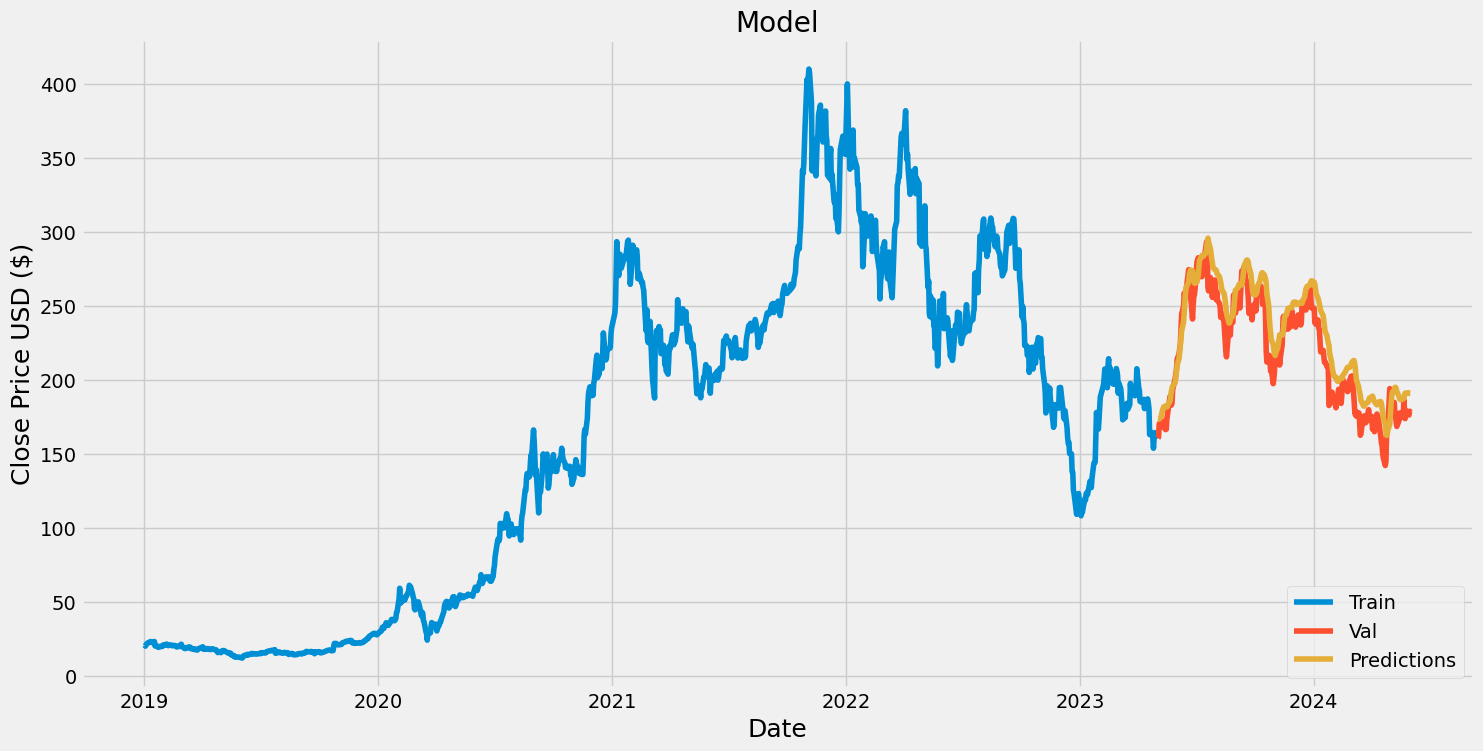

In [31]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()